In [11]:
import pickle
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import numpy as np
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cross_validation import train_test_split
pd.options.mode.chained_assignment = None
sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

with open("TEST_movie_data.pkl", 'r') as picklefile:
     all_movies = pickle.load(picklefile)
        
with open("director_movie_data.pkl", 'r') as picklefile:
     all_dir = pickle.load(picklefile)


,director,distributor,domestic_gross,foreign_gross,genre,imdb_budget,production_budget,rating,release_date,runtime,title,worldwide_gross
0,Joss Whedon,Buena Vista,623357910,896200000,Action / Adventure,220000000,220.0,PG-13,2012-05-04,142,Marvel's The Avengers,1519557910
1,Christopher Nolan,Warner Bros.,448139099,636300000,Action Thriller,250000000,250.0,PG-13,2012-07-20,165,The Dark Knight Rises,1084439099
2,Gary Ross,Lionsgate,408010692,283237076,Action / Adventure,78000000,78.0,PG-13,2012-03-23,142,The Hunger Games,691247768
3,Sam Mendes,Sony / Columbia,304360277,804200736,Action,200000000,200.0,PG-13,2012-11-09,143,Skyfall,1108561013
4,Peter Jackson,Warner Bros.,303003568,714000000,Fantasy,180000000,0.0,PG-13,2012-12-14,166,The Hobbit: An Unexpected Journey,1017003568
5,Bill Condon,Lionsgate/Summit,292324737,537360640,Romance,0,120.0,PG-13,2012-11-16,116,The Twilight Saga: Breaking Dawn Part 2,829685377
6,Marc Webb,Sony / Columbia,262030663,495900000,Action / Adventure,230000000,230.0,PG-13,2012-07-03,136,The Amazing Spider-Man,757930663
7,Mark Andrews,Buena Vista,237283207,301700000,Animation,185000000,185.0,PG,2012-06-22,100,Brave,538983207
8,Seth MacFarlane,Universal,218815487,330552828,Comedy,50000000,50.0,R,2012-06-29,106,Ted,549368315
9,Eric Darnell,Paramount (DreamWorks),216391482,530529792,Animation,145000000,145.0,PG,2012-06-08,93,Madagascar 3: Europe's Most Wanted,746921274


In [3]:
dir_df = pd.DataFrame(all_dir)
dir_df['lifetime_films'] = dir_df['lifetime_films'].astype('int')
dir_df.head()

,director,lifetime_films,lifetime_gross
0,Steven Spielberg,27,4155901520
1,Michael Bay,11,2143487601
2,Peter Jackson,12,2134703921
3,Robert Zemeckis,16,2039446164
4,James Cameron,9,1974307733


In [46]:
df = pd.DataFrame(all_movies)
df['production_budget'] = df['production_budget']*1000000
df['budget'] = 0
df['budget'][df['imdb_budget'] != 0]  = df['imdb_budget']
df['budget'][df['imdb_budget'] == 0]  = df['production_budget']
df['month'] = df['release_date'].map(lambda x: x.month)
df['worldwide_gross'] = df['worldwide_gross'].where(df['worldwide_gross']!=0, np.nan) 
df['foreign_gross'] = df['foreign_gross'].where(df['foreign_gross']!=0, np.nan) 
df['budget'] = df['budget'].where(df['budget']!=0, np.nan) 
df = df.sort(['domestic_gross'], ascending = False)
df = df[df.budget <= 270000000]
df = df.merge(dir_df,on='director')
#df['budget_var'] = df['production_budget']-df['imdb_budget']
df['lifetime_films'] = df['lifetime_films'].where(df['lifetime_films']!=0, np.nan) 
df['lifetime_gross'] = df['lifetime_gross'].where(df['lifetime_gross']!=0, np.nan) 
df['lifetime_films'] = df['lifetime_films'].astype('int')
#df = df.sort(['budget_var'], ascending = False)
#Fixing values - don't do this in real life!!!  Just fix the scraper.
df.set_value(178, 'budget', 65000000)
df.set_value(179, 'budget', 125000000)
df.set_value(141, 'budget', 150000000)
df.set_value(371, 'budget', 30000000)
df.set_value(345, 'budget', 35000000)
df.set_value(150, 'budget', 100000000)
df.set_value(330, 'budget', 45000000)
df.set_value(133, 'budget', 100000000)
df.set_value(269, 'budget', 28000000)
df.set_value(127, 'budget', 40000000)
df.set_value(258, 'budget', 10000000)
df.set_value(308, 'budget', 3500000)
df.set_value(235, 'budget', 4000000)
df.set_value(234, 'budget', 2000000)
df.set_value(329, 'budget', 16000000)

df['roi'] = df['worldwide_gross']/df['budget']
df['roi'] = df['roi'].where(df['roi']!=0, np.nan)
df['dir_average']  = df['lifetime_gross']/df['lifetime_films']
df = df.sort(['roi'], ascending = False)
#df['films_bins'] = 0
#df['films_bins'] = df['films_bins'].where(df['lifetime_films']<10, 10)
#df['films_bins'] = df['films_bins'].where(df['lifetime_films']>=10, 0)
df = df[df.roi < 40]
df
#cleandf = df[(df['budget_var']!=0) & (df['production_budget']!=0) & (df['imdb_budget']!=0)]
#cleandf

,director,distributor,domestic_gross,foreign_gross,genre,imdb_budget,production_budget,rating,release_date,runtime,title,worldwide_gross,budget,month,lifetime_films,lifetime_gross,roi,dir_average
135,John R. Leonetti,Warner Bros. (New Line),84273813,171000000,Horror,6500000,6500000,R,2014-10-03,95,Annabelle,255273813,6500000,10,2,120201219,39.272894,6.010061e+07
66,James Wan,FilmDistrict,83586447,78332871,Horror,0,5000000,PG-13,2013-09-13,105,Insidious Chapter 2,161919318,5000000,9,7,708372351,32.383864,1.011961e+08
234,Michael Tiddes,Open Road Films,40041683,20100000,Comedy,2000000,2500000,R,2013-01-11,80,A Haunted House,60141683,2000000,1,2,57371169,30.070842,2.868558e+07
152,James DeMonaco,Universal,64473115,24855512,Thriller,3000000,3000000,R,2013-06-07,85,The Purge,89328627,3000000,6,2,136435915,29.776209,6.821796e+07
196,Henry Joost,Paramount,53900335,88917657,Horror,5000000,5000000,R,2012-10-19,95,Paranormal Activity 4,142817992,5000000,10,3,161166485,28.563598,5.372216e+07
213,Scott Derrickson,Lionsgate/Summit,48086903,29625536,Horror,3000000,3000000,R,2012-10-12,110,Sinister,77712439,3000000,10,4,233103457,25.904146,5.827586e+07
87,Josh Boone,Fox,124872350,182366663,Drama,12000000,12000000,PG-13,2014-06-06,125,The Fault in our Stars,307239013,12000000,6,2,124953421,25.603251,6.247671e+07
98,Steven Soderbergh,Warner Bros.,113721571,53500000,Comedy / Drama,7000000,7000000,R,2012-06-29,110,Magic Mike,167221571,7000000,6,26,1039340590,23.888796,3.997464e+07
205,Stiles White,Universal,50856010,51673769,Horror,5000000,5000000,PG-13,2014-10-24,89,Ouija,102529779,5000000,10,1,50856010,20.505956,5.085601e+07
65,James Wan,Warner Bros.,137400141,180600000,Horror,20000000,20000000,R,2013-07-19,112,The Conjuring,318000141,20000000,7,7,708372351,15.900007,1.011961e+08


In [59]:
newdf = df[(df['lifetime_films']>1)]
newdf['gross_less_current'] = newdf['lifetime_gross']-newdf['worldwide_gross']
newdf['films_less_current'] = newdf['lifetime_films']-1
newdf['new_dir_average'] = newdf['gross_less_current'] / newdf['films_less_current']
newdf = newdf.sort(['new_dir_average'], ascending = True)
newdf = newdf[(newdf['new_dir_average']>0)& (newdf['new_dir_average']<300000000)]
#newdf = newdf[['new_dir_average','title']]
newdf

,director,distributor,domestic_gross,foreign_gross,genre,imdb_budget,production_budget,rating,release_date,runtime,...,worldwide_gross,budget,month,lifetime_films,lifetime_gross,roi,dir_average,gross_less_current,films_less_current,new_dir_average
315,Ed Gass-Donnelly,CBS Films,15179302,NaN,Horror,5000000,5000000,PG-13,2013-03-01,88,...,15179302,5000000,3,2,15210435,3.035860,7.605218e+06,31133,1,3.113300e+04
230,Alejandro González Iñárritu,Fox Searchlight,42340598,60874496,Comedy / Drama,22000000,18000000,R,2014-10-17,119,...,103215094,22000000,10,5,103443615,4.691595,2.068872e+07,228521,4,5.713025e+04
347,James Ponsoldt,A24,6854611,NaN,Comedy / Drama,2500000,0,R,2013-08-02,95,...,6854611,2500000,8,3,7255633,2.741844,2.418544e+06,401022,2,2.005110e+05
370,Zal Batmanglij,Fox Searchlight,2301839,99671,Drama,6500000,0,PG-13,2013-05-31,116,...,2401510,6500000,5,2,2709854,0.369463,1.354927e+06,308344,1,3.083440e+05
376,Lynn Shelton,IFC,1636190,NaN,Comedy / Drama,125000,0,R,2012-06-15,90,...,1636190,125000,6,5,3153205,13.089520,6.306410e+05,1517015,4,3.792538e+05
367,Michael Cuesta,Focus Features,2450846,NaN,Thriller,5000000,0,R,2014-10-10,112,...,2450846,5000000,10,4,3693971,0.490169,9.234928e+05,1243125,3,4.143750e+05
163,Miguel Arteta,Buena Vista,66954149,33700000,Family,28000000,28000000,PG,2014-10-10,81,...,100654149,28000000,10,5,104170504,3.594791,2.083410e+07,3516355,4,8.790888e+05
381,Oren Moverman,Millennium Ent.,972512,NaN,Crime Drama,1200000,0,R,2012-02-10,107,...,972512,1200000,2,2,2082172,0.810427,1.041086e+06,1109660,1,1.109660e+06
361,Michael Dowse,CBS Films,3493000,4354000,Romantic Comedy,11000000,0,PG-13,2014-08-08,102,...,7847000,11000000,8,3,10541688,0.713364,3.513896e+06,2694688,2,1.347344e+06
399,Steven Knight,Roadside Attractions,36895,NaN,Action Thriller,20000000,0,R,2013-06-28,100,...,36895,20000000,6,2,1412664,0.001845,7.063320e+05,1375769,1,1.375769e+06


In [79]:
y, X = dmatrices('worldwide_gross ~ budget + new_dir_average + month  ', data=newdf, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     127.7
Date:                Fri, 17 Jul 2015   Prob (F-statistic):           8.52e-49
Time:                        10:17:49   Log-Likelihood:                -4704.5
No. Observations:                 235   AIC:                             9417.
Df Residuals:                     231   BIC:                             9431.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -5.221e+07   2.03e+07     -2.571      0.011     -9.22e+07 -1.22e+07
budget              2.7725      0.157     17.670      0.000         2.463     3.082
new_dir_average     0.1775      0.209      0.850      0.396        -0.234     0.589
month            6.675e+06   2.28e+06      2.926      0.004      2.18e+06  1.12e+07
==============================================================================
Omnibus:                       59.510   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.883
Skew:                           0.953   Prob(JB):                     1.81e-53
Kurtosis:                       7.601   Cond. No.                     2.34e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

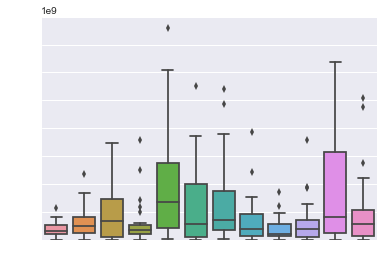

In [44]:
sns.set_palette("husl")
sns.boxplot(x = "month", y = "worldwide_gross", data = df.sort("month"))
ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.show()

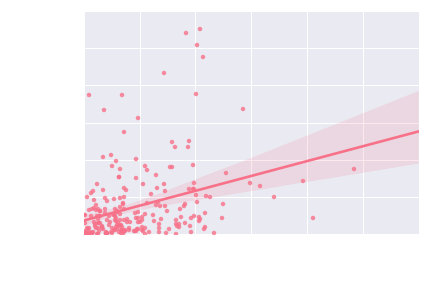

In [83]:
sns.regplot(x="new_dir_average", y="worldwide_gross", data=newdf)
ax = plt.gca()
plt.xlabel("Director Average")
plt.ylabel("Worldwide Gross")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

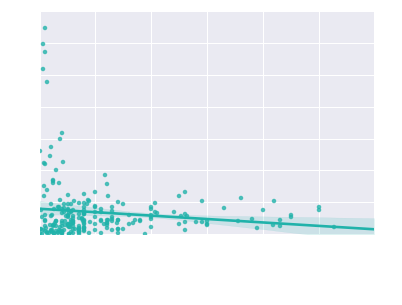

In [81]:
sns.regplot(x="budget", y="roi", data=newdf, color = '#20B2AA')
ax = plt.gca()
plt.xlabel("Budget")
plt.ylabel("ROI")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

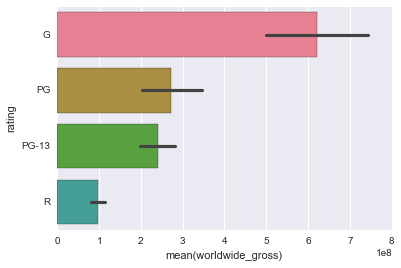

In [76]:
rating_df = df[(df["rating"] == "G") | (df['rating'] == "PG") | (df['rating'] == "PG-13") | (df['rating'] == "R")]
sns.barplot(x="worldwide_gross", y="rating", data=rating_df.sort('rating'))
"""ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')"""
plt.show()

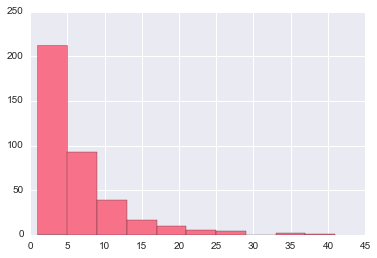

In [553]:
df.lifetime_films.hist()

newdf.worldwide_gross.hist()

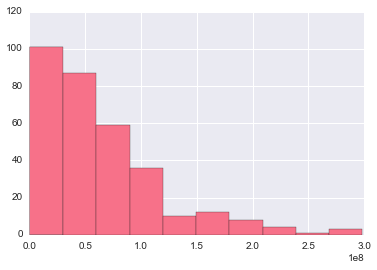

In [554]:
newdf.dir_average.hist()

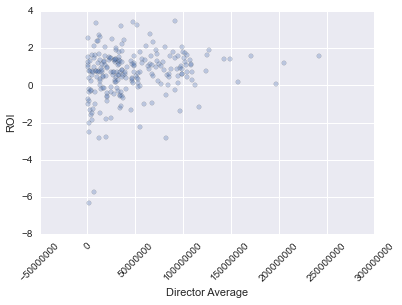

In [66]:
plt.scatter(newdf.new_dir_average, np.log(newdf.roi), alpha=0.3)
plt.xlabel("Director Average")
plt.ylabel("ROI")
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.show()

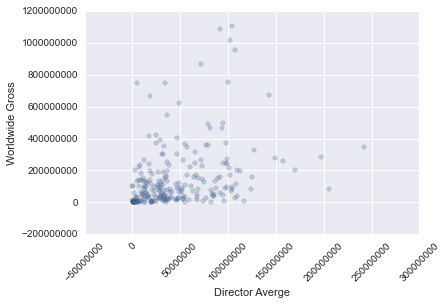

In [67]:
plt.scatter(X.new_dir_average, y, alpha=0.3)
plt.xlabel("Director Averge")
plt.ylabel("Worldwide Gross")
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.show()

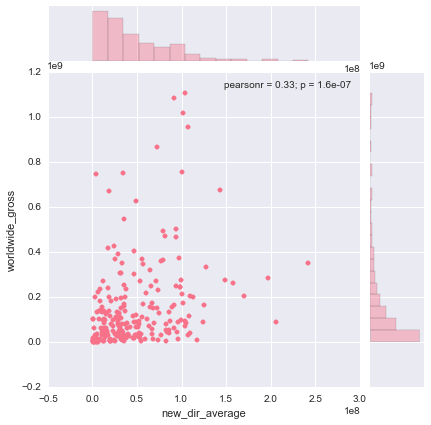

In [74]:
sns.jointplot(x='new_dir_average', y='worldwide_gross', data=newdf)

In [558]:
#simple_df = df[['director','distributor', 'genre', 'domestic_gross', 'budget', 'release_date', 'runtime','title','month', 
#               'lifetime_gross', 'lifetime_films', 'roi']]
#g = sns.PairGrid(simple_df)

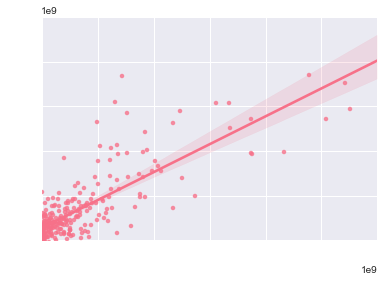

In [82]:
ypred = results.predict()
sns.regplot(x=y, y=ypred, data = newdf)
plt.xlabel("Actual Gross")
plt.ylabel("Predicted Gross")
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.show()

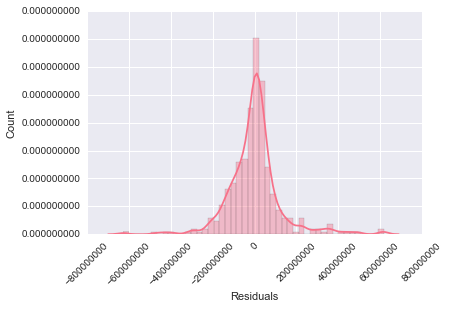

In [560]:
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.ticklabel_format(useOffset=False, style='plain')
yres = results.resid
sns.distplot(yres)
plt.xticks(rotation=45)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()

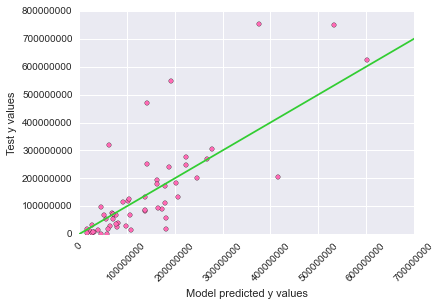

In [69]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

ytestpred = model.predict(x_test)
plt.scatter(x=ytestpred, y=y_test, c = "#FF69B4")
plt.xlabel("Model predicted y values")
plt.ylabel("Test y values")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.ticklabel_format(useOffset=False, style='plain')
#ax.set_xticks(np.arange(0, 30, 5))
#ax.set_yticks(np.arange(0, 30, 5))
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xticks(rotation=45)
plt.plot([0,1000000000],[0,1000000000],'#32CD32')
"""ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')"""
plt.show()

In [70]:
model = sm.OLS(y_test, x_test)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     32.82
Date:                Fri, 17 Jul 2015   Prob (F-statistic):           2.69e-12
Time:                        10:13:39   Log-Likelihood:                -1172.9
No. Observations:                  59   AIC:                             2354.
Df Residuals:                      55   BIC:                             2362.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -7.405e+07   3.65e+07     -2.027      0.047     -1.47e+08 -8.56e+05
budget              3.0868      0.331      9.322      0.000         2.423     3.750
new_dir_average     0.2466      0.424      0.581      0.563        -0.603     1.097
month            8.141e+06   4.19e+06      1.945      0.057     -2.47e+05  1.65e+07
==============================================================================
Omnibus:                       26.475   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.889
Skew:                           1.432   Prob(JB):                     5.40e-12
Kurtosis:                       6.592   Cond. No.                     2.08e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
model = sm.OLS(y_train, x_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     94.36
Date:                Fri, 17 Jul 2015   Prob (F-statistic):           3.80e-36
Time:                        10:13:44   Log-Likelihood:                -3529.6
No. Observations:                 176   AIC:                             7067.
Df Residuals:                     172   BIC:                             7080.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -4.694e+07   2.45e+07     -1.917      0.057     -9.53e+07  1.38e+06
budget              2.7125      0.182     14.945      0.000         2.354     3.071
new_dir_average     0.1741      0.243      0.716      0.475        -0.306     0.654
month            6.105e+06   2.73e+06      2.239      0.026      7.23e+05  1.15e+07
==============================================================================
Omnibus:                       47.057   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.020
Skew:                           0.935   Prob(JB):                     1.22e-42
Kurtosis:                       7.777   Cond. No.                     2.44e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What is the probability a movie doubles it's initial investment given that it's director has made 10 or more movies?

In [564]:
recoup = len(df[df.roi > 2.0])
total = len(df)
per_recoup = float(recoup)/float(total)
print recoup, "/", total
print "P(recoup):", per_recoup

251 / 383
P(recoup): 0.655352480418


In [565]:
high_vol_dir = len(dir_df[(dir_df['lifetime_films']>5.0)])
total_dir = len(dir_df)
per_dir = float(high_vol_dir)/float(total_dir)
print high_vol_dir, "/", total_dir
print "P(director more than 10 films):", per_dir

237 / 827
P(director more than 10 films): 0.286577992745


In [566]:
bayes_df = df[(df['roi']>2.0)]
high_vol_dir_given_recoup = len(bayes_df[bayes_df.lifetime_films > 5])
per_given = float(high_vol_dir_given_recoup/float(len(bayes_df)))
print high_vol_dir_given_recoup, "/", len(bayes_df)
print "P(dir more than 10 films given film recoup):", per_given

83 / 251
P(dir more than 10 films given film recoup): 0.330677290837


In [567]:
bayes_calc = (per_given*per_recoup)/per_dir
print bayes_calc

0.756199667295


In [568]:
final_df = df[(df.lifetime_films > 10) & (df.roi > 2.0)]
final_df

,director,distributor,domestic_gross,foreign_gross,genre,imdb_budget,production_budget,rating,release_date,runtime,title,worldwide_gross,budget,month,lifetime_films,lifetime_gross,budget_var,roi,dir_average,films_bins
26,Michael Bay,Paramount,245439076,858600000,Sci-Fi Action,210000000,210000000,PG-13,2014-06-27,165,Transformers: Age of Extinction,1104039076,210000000,6,11,2143487601,0,5.257329,1.948625e+08,10
27,Michael Bay,Paramount,49875291,36300000,Action,0,26000000,R,2013-04-26,129,Pain and Gain,86175291,26000000,4,11,2143487601,26000000,3.314434,1.948625e+08,10
14,Peter Jackson,Warner Bros.,255119788,700000000,Fantasy,250000000,0,PG-13,2014-12-17,144,The Hobbit: The Battle of the Five Armies,955119788,250000000,12,12,2134703921,-250000000,3.820479,1.778920e+08,10
13,Peter Jackson,Warner Bros.,303003568,714000000,Fantasy,180000000,0,PG-13,2012-12-14,166,The Hobbit: An Unexpected Journey,1017003568,180000000,12,12,2134703921,-180000000,5.650020,1.778920e+08,10
49,Steven Spielberg,Buena Vista,182207973,93085477,Historical Drama,65000000,65000000,PG-13,2012-11-09,145,Lincoln,275293450,65000000,11,27,4155901520,0,4.235284,1.539223e+08,10
119,Robert Zemeckis,Paramount,93772375,68000000,Drama,31000000,31000000,R,2012-11-02,139,Flight,161772375,31000000,11,16,2039446164,0,5.218464,1.274654e+08,10
31,Sam Raimi,Buena Vista,234911825,258400000,Adventure,215000000,215000000,PG,2013-03-08,127,Oz The Great and Powerful,493311825,215000000,3,14,1526694668,0,2.294474,1.090496e+08,10
142,Tim Burton,Buena Vista,35291068,46200000,Animation,39000000,39000000,PG,2012-10-05,87,Frankenweenie,81491068,39000000,10,17,1752990124,0,2.089515,1.031171e+08,10
143,Tim Burton,Weinstein Company,14482031,14771135,Drama,10000000,0,PG-13,2014-12-25,106,Big Eyes,29253166,10000000,12,17,1752990124,-10000000,2.925317,1.031171e+08,10
95,Shawn Levy,Fox,113746621,246625469,Family Adventure,127000000,127000000,PG,2014-12-19,97,Night at the Museum: Secret of the Tomb,360372090,127000000,12,11,1130331333,0,2.837576,1.027574e+08,10


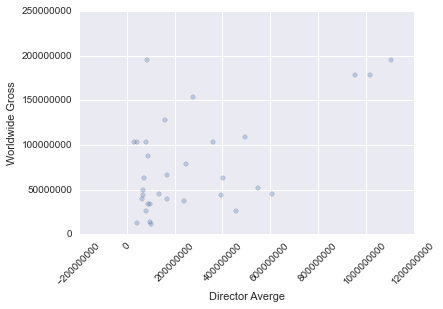

In [569]:
plt.scatter(final_df.worldwide_gross, final_df.dir_average, alpha=0.3)
plt.xlabel("Director Averge")
plt.ylabel("Worldwide Gross")
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.show()